In [1]:
import numpy as np
import torch
import copy
import torch.nn.functional as F
from torch.nn import DataParallel

from torch import nn, optim
from PIL import ImageFile, Image

import pandas as pd
import io 

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
multi_gpus = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    multi_gpus = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class SEBlock(nn.Module):

    def __init__(self, planes, ratio):

        super(SEBlock, self).__init__()

        self.se_pool = nn.AdaptiveAvgPool2d((1,1))
        self.se_fc1 = nn.Linear(planes, planes // ratio)
        self.relu = nn.ReLU(inplace=True)
        self.se_fc2 = nn.Linear(planes // ratio, planes)

    def forward(self, x):

        out = self.se_pool(x)
        out = torch.flatten(out, 1)
        out = self.se_fc1(out)
        #print(out.shape)
        out = F.relu(out)
        out = self.se_fc2(out)
        out = torch.sigmoid(out)
        out = out.view(out.size(0), out.size(1), 1, 1)
        #print(x.shape)
        #print(out.shape)
        out = torch.mul(out.expand_as(x), x)

        return out

In [4]:
class ConvBlock(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=True):

        super(ConvBlock, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        pad = 0
        if padding :
            pad = (self.kernel_size - 1) // 2

        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding=pad, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_planes, momentum=0.99)
        self.leaky_relu = nn.LeakyReLU(0.1, inplace=True)

    def forward(self, x):

        output = self.conv(x)
        output = self.batchnorm(output)
        output = self.leaky_relu(output)

        return output

In [5]:
class DarknetBlock(nn.Module):

    def __init__(self, out_planes):

        super(DarknetBlock, self).__init__()
        self.inplanes = out_planes * 2
        self.conv1 = ConvBlock(self.inplanes, out_planes, 1)
        self.conv2 = ConvBlock(out_planes, self.inplanes, 3)
        self.se = SEBlock(self.inplanes, ratio=16)

    def forward(self, x):

        shortcut = x
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.se(output)
        output = output + shortcut

        return output

In [6]:
class Darknet(nn.Module):

    def __init__(self, num_classes=1000):

        super(Darknet, self).__init__()   

        self.conv_block1 = ConvBlock(3, 32, 3, 1)
        self.conv_block2 = ConvBlock(32, 64, 3, 2)

        self.dark_block1 = DarknetBlock(32)

        self.conv_block3 = ConvBlock(64, 128, 3, 2)

        self.dark_layer1 = self._make_blocks(2, 64)
        
        self.conv_block4 = ConvBlock(128, 256, 3, 2)

        self.dark_layer2 = self._make_blocks(2, 128)

        self.conv_block5 = ConvBlock(256, 512, 3, 2)

        self.dark_layer3 = self._make_blocks(2, 256)

        self.conv_block6 = ConvBlock(512, 1024, 3, 2)

        self.dark_layer4 = self._make_blocks(2, 512)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        self.fc = nn.Linear(1024, num_classes)

    def _make_blocks(self, num_blocks, out_planes):
        blocks = []
        for _ in range(num_blocks):
            blocks.append(DarknetBlock(out_planes))

        return nn.Sequential(*blocks)

    def forward(self, x, feature=False):

        output = self.conv_block1(x)
        output = self.conv_block2(output)

        output = self.dark_block1(output)

        output = self.conv_block3(output)

        output = self.dark_layer1(output)

        output = self.conv_block4(output)

        output = self.dark_layer2(output)

        output = self.conv_block5(output)

        output = self.dark_layer3(output)

        output = self.conv_block6(output)

        output = self.dark_layer4(output)

        output = self.avgpool(output)

        output = torch.flatten(output, 1)
        
        if feature:
            return output

        output = self.fc(output)
        
        return output

In [7]:
model = Darknet(num_classes=15)

In [8]:
inputs = torch.randn((1,3,224,224))
outputs = model(inputs)

In [9]:
outputs.shape

torch.Size([1, 15])

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
count_parameters(model)

20616995

In [12]:
import apex
print("using apex synced BN")
model = apex.parallel.convert_syncbn_model(model)

using apex synced BN


In [13]:
optimizer = optim.SGD(model.parameters(), lr=1., momentum=0.9, weight_decay=5e-4, nesterov=True)
#optimizer = optim.SGD(model.parameters(),lr=0.5)

In [14]:
from apex import amp, optimizers

model, optimizer = amp.initialize(model.cuda(), optimizer, opt_level='O3',keep_batchnorm_fp32=True)

Selected optimization level O3:  Pure FP16 training.
Defaults for this optimization level are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : False
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O3
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : False
loss_scale             : 1.0


In [15]:
def pad_shorter(x):
    h,w = x.size[-2:]
    s = max(h, w) 
    new_im = Image.new("RGB", (s, s))
    new_im.paste(x, ((s-h)//2, (s-w)//2))
    return new_im

In [20]:
import torchvision
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader


def get_transform(train=True):
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
    transform = []
    #transform.append(transforms.Resize([224,224]))
    if train:
        transform.append(transforms.Resize([300, 300]))  
        #transform.append(transforms.CenterCrop([224, 224]))          
        #transform.append(transforms.CenterCrop(256))
        transform.append(transforms.RandomCrop(224))
        transform.append(transforms.RandomHorizontalFlip())
    else:
        transform.append(transforms.Resize([300,300]))
        transform.append(transforms.CenterCrop([224, 224]))          

    transform.append(transforms.ToTensor())
    transform.append(normalize)
    return transforms.Compose(transform)

class FashionDataset(Dataset):
    
    def __init__(self, pkl_file, transform=None):
        
        from google.cloud import storage
        client = storage.Client()
        self.bucket = client.get_bucket('urbandetection')         
        self.transform = transform
        self.items = pd.read_pickle(pkl_file)

       
        
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        
        rows = self.items.iloc[idx]
        
        #print(rows)
        name = rows['key']
        label = rows['패턴']

        blob = self.bucket.get_blob(name)
        img_str = blob.download_as_string()
        img = Image.open(io.BytesIO(img_str))
        
        if self.transform is not None:
            sample = self.transform(img)
        else:
            sample = np.asarray(img)
            
        
        return sample, label

In [28]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    _ = plt.figure(figsize=(15,15))

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [18]:
test_dataset = FashionDataset('./datasets/pattern_balance_train.pkl', transform=get_transform(train=True))

In [19]:
test_loader = DataLoader(dataset=test_dataset, batch_size=4)

tensor([ 6, 13, 14,  3])


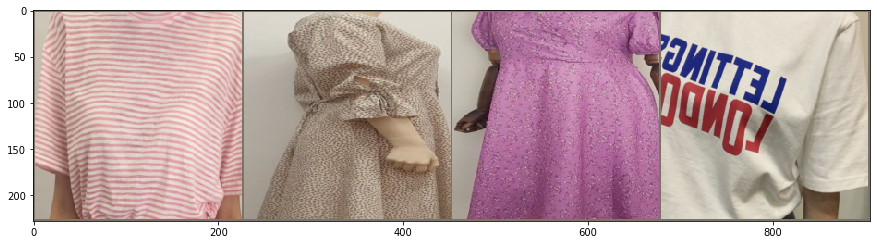

In [20]:
import torchvision
from torchvision import datasets, transforms

inputs, labels = next(iter(test_loader))
    #print(data)
out = torchvision.utils.make_grid(inputs)
print(labels)

imshow(out)

In [21]:
train_dataset = FashionDataset('./datasets/pattern_balance_train.pkl', transform=get_transform(train=True))
val_dataset = FashionDataset('./datasets/pattern_valid.pkl',  transform=get_transform(train=False))
#test_dataset = FashionDataset('./datasets/pattern_test.pkl',  transform=get_transform(train=False))

In [27]:
tr_loader = DataLoader(dataset=train_dataset,
                            batch_size=256,
                            shuffle=True,
                            pin_memory=True,
                            num_workers=16)

val_loader = DataLoader(dataset=val_dataset,
                             batch_size=16,
                             #shuffle=False,
                             pin_memory=True,                             
                             num_workers=16)

In [24]:
class_to_idx ={'기하학': 0, '도트': 1, '레오파드': 2, '레터링': 3, '로고': 4, '무지': 5, '스트라이프': 6, '아가일': 7, \
               '지브라': 8, '체크': 9, '카모플라쥬': 10, '캐릭터': 11, '파이톤': 12, '프린트': 13, '플라워': 14}

In [29]:
len(tr_loader)

241

In [35]:
criterion = nn.CrossEntropyLoss()#.cuda()
#criterion = nn.NLLLoss().cuda()

In [26]:
import math
from torch.autograd import Variable

def find_lr(init_value = 1e-8, final_value=10., beta = 0.98, trn_loader = tr_loader):
    num = len(trn_loader)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for data in trn_loader:
        batch_num += 1
        #As before, get the loss for this mini-batch of inputs/outputs
        inputs,labels = data
        inputs = inputs.cuda(non_blocking=True)        
        labels = labels.cuda(non_blocking=True)        
        #inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.cpu().data
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        #loss.backward()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()        
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

In [29]:
logs,losses = find_lr(trn_loader = tr_loader)

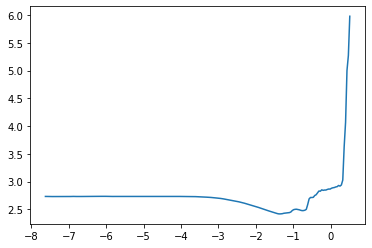

In [30]:
import matplotlib.pyplot as plt

plt.plot(logs[10:-5],losses[10:-5])


In [31]:
logs[np.argmin(losses)]

-1.3625000000000034

In [33]:
(10.0)**(-1.3625000000000034)

0.043401026364474043

In [34]:
math.log10(0.05)

-1.3010299956639813

In [31]:
torch.cuda.synchronize()
model.train()
for _ in range(2):
    inputs, labels = next(iter(tr_loader))
    print(1)
    inputs = inputs.cuda(non_blocking=True)        
    labels = labels.cuda(non_blocking=True)    
    print(2)    
    logits = model(inputs)
    print(3)                       
    loss = criterion(logits, labels)                   
    print(4)                   
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()
    print(5)                            
    model.zero_grad()
    print(10)                                
torch.cuda.synchronize()

1
2
3
4
5
10
1
2
3
4
5
10


In [32]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [33]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [36]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.05, steps_per_epoch=len(tr_loader)
                                                , epochs=20, pct_start=0.2)

In [37]:
def classification_val(model, val_loader):
    correct = 0
    total = 0    
    
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            loss += loss.item()
            correct += (predicted == labels).sum().item()
            #print(loss.item()/inputs.size(0))
    return correct/total, loss.cpu()

In [40]:
import datetime
import time
high = 0.0
epoch_time = AverageMeter('Epoch', ':6.3f')
batch_time = AverageMeter('Batch', ':6.3f')
data_time = AverageMeter('Data', ':6.3f')
losses = AverageMeter('Loss', ':.5f')
learning_rates = AverageMeter('LearningRate', ':.5f')
top1 = AverageMeter('Acc@1', ':6.2f')
top3 = AverageMeter('Acc@3', ':6.2f')

for epoch in range(15, 20):  # loop over the dataset multiple times
    time_ = datetime.datetime.now()    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    progress = ProgressMeter(
        len(tr_loader),
        [batch_time, data_time, losses, top1, top3, learning_rates],
        prefix="Epoch: [{}]".format(epoch))
    
    end = time.time()    
    for i, (inputs, labels) in enumerate(tr_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #print(inputs.shape)
        #print(labels.shape)
        data_time.update(time.time() - end)
        inputs = inputs.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        #_, preds = torch.max(outputs, 1)
        #loss.backward()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
            
        optimizer.step()
        scheduler.step()
        # print statistics
        acc1, acc3 = accuracy(outputs, labels, topk=(1,3))
        losses.update(loss.item(), inputs.size(0))
        learning_rates.update(scheduler.get_lr()[0])        
        top1.update(acc1[0], inputs.size(0))
        top3.update(acc3[0], inputs.size(0))

        
        batch_time.update(time.time() - end)
        if i % 100 == 99:    # print every 2000 mini-batches
            progress.display(i)
            #running_loss = 0.0
    elapsed = datetime.datetime.now() - time_
    val_acc, val_loss = classification_val(model, val_loader)
    print('{} elapsed for {} val acc : {}, val loss : {:.5f}'.format(elapsed, epoch+1, val_acc, val_loss))

    
print('Finished Training')

Epoch: [15][ 99/241]	Batch 181.646 (98.189)	Data 181.353 (97.892)	Loss 0.66719 (0.79121)	Acc@1  76.95 ( 73.79)	Acc@3  94.14 ( 93.60)	LearningRate 0.00671 (0.00742)
Epoch: [15][199/241]	Batch 333.690 (177.354)	Data 333.396 (177.058)	Loss 0.86733 (0.79034)	Acc@1  70.31 ( 73.84)	Acc@3  93.36 ( 93.53)	LearningRate 0.00539 (0.00673)
0:06:28.624749 elapsed for 16 val acc : 0.7434980494148244, val loss : 1.14683
Epoch: [16][ 99/241]	Batch 181.388 (176.102)	Data 181.095 (175.807)	Loss 0.78886 (0.78204)	Acc@1  76.95 ( 74.24)	Acc@3  93.36 ( 93.60)	LearningRate 0.00374 (0.00582)
Epoch: [16][199/241]	Batch 333.569 (193.713)	Data 333.276 (193.417)	Loss 0.79094 (0.77742)	Acc@1  73.83 ( 74.46)	Acc@3  93.36 ( 93.71)	LearningRate 0.00274 (0.00523)
0:06:24.084902 elapsed for 17 val acc : 0.7539011703511054, val loss : 1.52177
Epoch: [17][ 99/241]	Batch 177.813 (188.573)	Data 177.520 (188.278)	Loss 0.66304 (0.76835)	Acc@1  79.30 ( 74.73)	Acc@3  95.70 ( 93.86)	LearningRate 0.00158 (0.00448)
Epoch: [17][19

ValueError: Tried to step 4822 times. The specified number of total steps is 4820

In [63]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss,    
    
}, './checkpoint/pattern_ep20_cate15.b0.pth')

In [15]:
checkpoint = torch.load('./checkpoint/pattern_ep20_cate15.b0.pth', map_location='cpu')

In [16]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [17]:
import torchvision

def classification_test(model, val_loader):
    correct = 0
    total = 0    
    
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            out = torchvision.utils.make_grid(images)             
            #imshow(out)

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            #print([class_to_idx[item] for item in labels.cpu().numpy()])
            #print([class_to_idx[item] for item in predicted.cpu().numpy()])
            total += labels.size(0)
            loss += loss.item()
            correct += (predicted == labels).sum().item()
            #print(loss.item()/inputs.size(0))
    return correct/total, loss.cpu()

In [18]:
def test_transform(random_crop=True):
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
        std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
    transform = []
    transform.append(transforms.Resize([256, 256]))
    transform.append(transforms.CenterCrop([224, 224]))    

    transform.append(transforms.ToTensor())
    transform.append(normalize)
    return transforms.Compose(transform)

In [30]:
test_dataset = FashionDataset('./datasets/pattern_test.pkl', transform=test_transform())

In [31]:
test_loader = DataLoader(dataset=test_dataset,
                             batch_size=8,
                             shuffle=True,
                             num_workers=8)

In [56]:
test_acc, test_loss = classification_test(model, test_loader)
print('test acc : {}, test loss : {:.5f}'.format(test_acc, test_loss))

test acc : 0.743448098663926, test loss : 3.85388


In [32]:
class_names=[k for k,v in class_to_idx.items()]

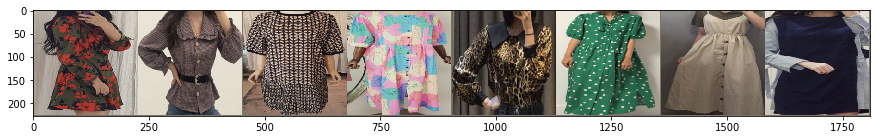

['플라워', '체크', '프린트', '기하학', '레오파드', '도트', '무지', '스트라이프']
['플라워', '체크', '기하학', '프린트', '레오파드', '도트', '무지', '체크']


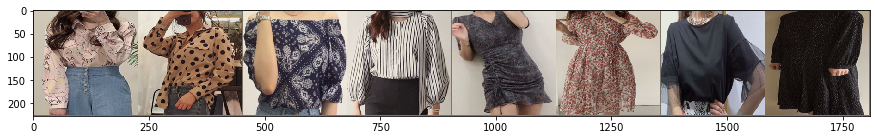

['레터링', '도트', '기하학', '스트라이프', '도트', '플라워', '무지', '도트']
['플라워', '도트', '기하학', '스트라이프', '플라워', '플라워', '무지', '도트']


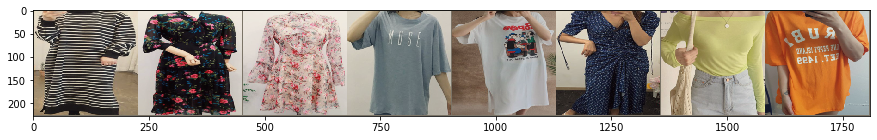

['스트라이프', '플라워', '플라워', '프린트', '캐릭터', '플라워', '무지', '프린트']
['스트라이프', '플라워', '플라워', '레터링', '프린트', '도트', '무지', '레터링']


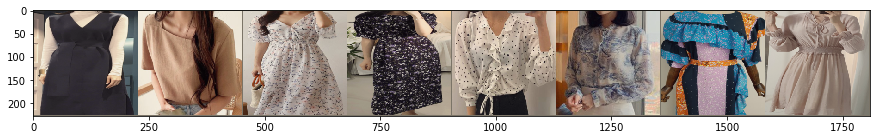

['무지', '무지', '플라워', '플라워', '도트', '프린트', '도트', '무지']
['무지', '무지', '플라워', '플라워', '도트', '플라워', '도트', '무지']


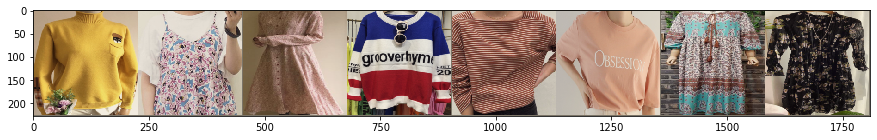

['캐릭터', '플라워', '플라워', '레터링', '스트라이프', '레터링', '프린트', '플라워']
['무지', '플라워', '플라워', '레터링', '스트라이프', '레터링', '기하학', '플라워']


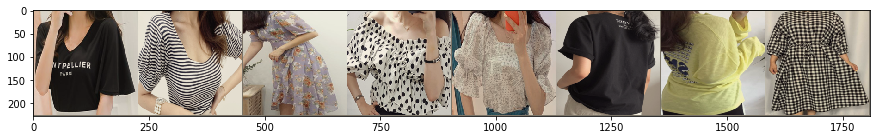

['레터링', '스트라이프', '플라워', '도트', '기하학', '레터링', '프린트', '체크']
['레터링', '스트라이프', '플라워', '도트', '무지', '레터링', '프린트', '체크']


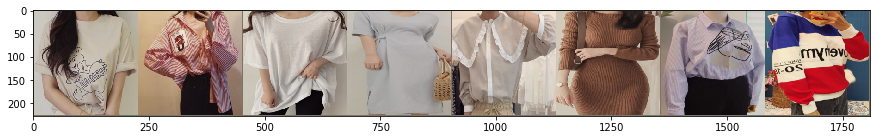

['캐릭터', '스트라이프', '레터링', '체크', '체크', '무지', '스트라이프', '레터링']
['캐릭터', '스트라이프', '레터링', '무지', '무지', '무지', '스트라이프', '레터링']


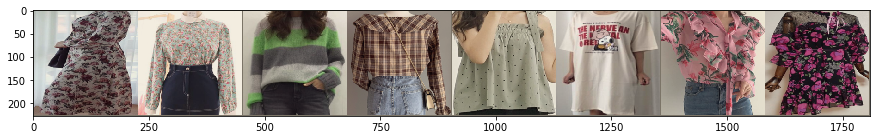

['플라워', '플라워', '스트라이프', '체크', '도트', '프린트', '플라워', '플라워']
['플라워', '플라워', '스트라이프', '체크', '도트', '프린트', '플라워', '플라워']


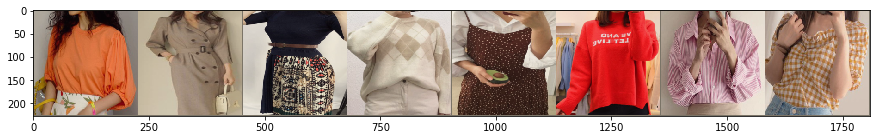

['프린트', '체크', '프린트', '아가일', '도트', '레터링', '스트라이프', '체크']
['무지', '무지', '무지', '아가일', '도트', '레터링', '스트라이프', '체크']


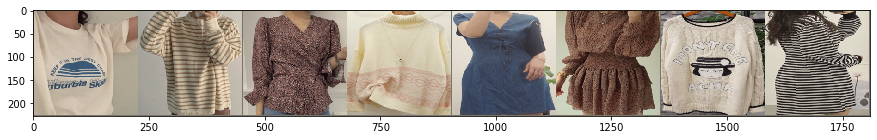

['레터링', '스트라이프', '레오파드', '기하학', '스트라이프', '레오파드', '캐릭터', '스트라이프']
['레터링', '스트라이프', '레오파드', '무지', '무지', '레오파드', '프린트', '스트라이프']


In [37]:
model.eval()
with torch.no_grad():
    for _ in range(10):
        data = next(iter(test_loader))

        images, labels = data
        out = torchvision.utils.make_grid(images)             
        imshow(out)

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs.data, 1)
        print([class_names[item] for item in labels.cpu().numpy()])
        print([class_names[item] for item in predicted.cpu().numpy()])
        #total += labels.size(0)
        #loss += loss.item()
        #correct += (predicted == labels).sum().item()